In [4]:
import numpy as np
import pandas as pd

In [5]:
train_df=pd.read_csv('data/Stress_1.txt',delimiter=';',header=None,names=['text','label'])
stress_df=pd.read_csv('data/Stress.csv')

# Mapping dictionary
label_mapping = {'sadness': 1, 'fear': 1, 'anger': 1,'love':0,'joy':0,'surprise':0}

# Replace labels with 1 and others with 0
train_df['label'] = train_df['label'].replace(label_mapping)
train_df['label'].fillna(0, inplace=True)
stress_df=stress_df.iloc[:,3:5]


/var/folders/yd/pz_sq3ls22x4rx6d_hv1svw80000gn/T/ipykernel_2356/2783605191.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['label'] = train_df['label'].replace(label_mapping)
/var/folders/yd/pz_sq3ls22x4rx6d_hv1svw80000gn/T/ipykernel_2356/2783605191.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

In [6]:
raw_df=pd.concat([stress_df,train_df],ignore_index=True)
df=raw_df
df['label'].value_counts()

label
1    10250
0     8588
Name: count, dtype: int64

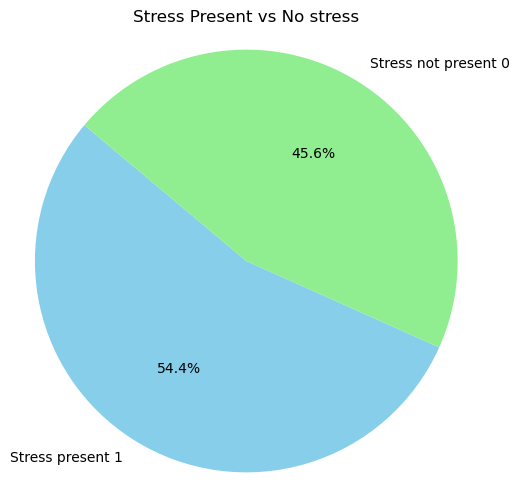

In [7]:
import matplotlib.pyplot as plt

# Sample binary dataset
labels = ['Stress present 1', 'Stress not present 0']
sizes=[sum(1 for label in df['label'] if label == 1),sum(1 for label in df['label'] if label == 0)]

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('Stress Present vs No stress')

# Show plot
plt.show()

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tr_text,ts_temp, tr_label,y_temp=train_test_split(df['text'], df['label'], test_size=0.3, random_state=42)
val_text,ts_text,val_label,ts_label=train_test_split(ts_temp, y_temp, test_size=0.5, random_state=42)

encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)


tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text)

sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50)
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)


max_words = 10000
max_len = (50,)
embedding_dim = 32

# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim,input_shape=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())


# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim,input_shape=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())


concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

model = Model(inputs=[branch1.inputs, branch2.inputs], outputs=output_layer)


model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()


batch_size = 256
epochs = 50
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))


(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 50)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 32)       320000      ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 32)       320000      ['embedding_1_input[0][0]']      
                                                                                              

2024-03-26 19:58:38.474384: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


52/52 [==============================] - 2s 19ms/step - loss: 0.7778 - accuracy: 0.5196 - precision: 0.5196 - recall: 0.5196 - val_loss: 0.6914 - val_accuracy: 0.5453 - val_precision: 0.5453 - val_recall: 0.5453
Epoch 2/50
52/52 [==============================] - 1s 19ms/step - loss: 0.6735 - accuracy: 0.5802 - precision: 0.5802 - recall: 0.5802 - val_loss: 0.6910 - val_accuracy: 0.5495 - val_precision: 0.5495 - val_recall: 0.5495
Epoch 3/50
52/52 [==============================] - 1s 19ms/step - loss: 0.6487 - accuracy: 0.6148 - precision: 0.6148 - recall: 0.6148 - val_loss: 0.6885 - val_accuracy: 0.6054 - val_precision: 0.6054 - val_recall: 0.6054
Epoch 4/50
52/52 [==============================] - 1s 22ms/step - loss: 0.5975 - accuracy: 0.6784 - precision: 0.6784 - recall: 0.6784 - val_loss: 0.6808 - val_accuracy: 0.7042 - val_precision: 0.7042 - val_recall: 0.7042
Epoch 5/50
52/52 [==============================] - 1s 21ms/step - loss: 0.5231 - accuracy: 0.7411 - precision: 0.7411 

KeyboardInterrupt: 

89/89 [==============================] - 0s 2ms/step
Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

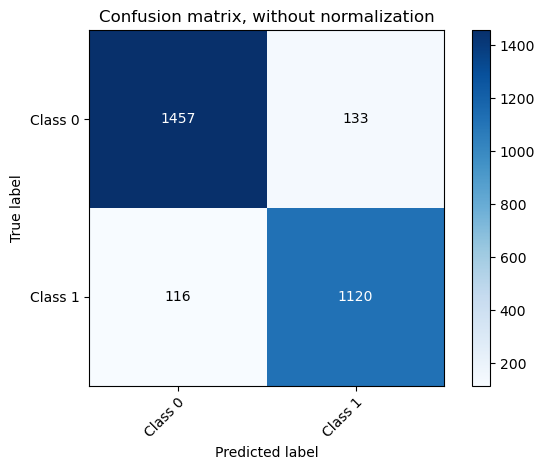

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import utils
x=model.predict([ts_x,ts_x])
y_predict=np.round(x)
y_true=ts_y[:,0]
y_predict=y_predict[:,0]

utils.plot_confusion_matrix(y_predict,y_true, ['Class 0', 'Class 1'])
